In [1]:
import navis
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_color_codes('muted')

In [2]:
nl = navis.example_neurons()
nl.cable_length

array([266476.88, 304332.66, 274703.38, 286522.47, 291265.3 ],
      dtype=float32)

In [3]:
df = nl.summary()
df.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,1734350788,1734350788,4465,2705,599,618,266476.87500,[4177],8 nanometer
1,navis.TreeNeuron,1734350908,1734350908,4847,3042,735,761,304332.65625,[6],8 nanometer
2,navis.TreeNeuron,722817260,722817260,4332,3136,633,656,274703.37500,None,8 nanometer
3,navis.TreeNeuron,754534424,754534424,4696,3010,696,726,286522.46875,[4],8 nanometer
4,navis.TreeNeuron,754538881,754538881,4881,2943,626,642,291265.31250,[701],8 nanometer


In [4]:
nl[0].soma

array([4177], dtype=int32)

In [5]:
nl[0].reroot(nl[0].soma)

,
type,navis.TreeNeuron
name,1734350788
id,1734350788
n_nodes,4465
n_connectors,2705
n_branches,598
n_leafs,619
cable_length,266476.875
soma,[4177]
units,8 nanometer


In [6]:
nl_soma = nl[nl.soma != None]
nl_soma.reroot(nl_soma.soma, inplace=False)

reroot:   0%|          | 0/4 [00:00<?, ?it/s]

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,1734350788,1734350788,4465,2705,598,619,266476.87500,[4177],8 nanometer
1,navis.TreeNeuron,1734350908,1734350908,4847,3042,734,762,304332.65625,[6],8 nanometer
2,navis.TreeNeuron,754534424,754534424,4696,3010,695,727,286522.46875,[4],8 nanometer
3,navis.TreeNeuron,754538881,754538881,4881,2943,625,643,291265.31250,[701],8 nanometer


In [7]:
# Downsample by "skipping" N nodes (here: 10)
nl_downsampled = nl.downsample(10, inplace=False)

# More elaborate: resample to given resolution
# (we can provide a "unit str" here because our neurons have their units set)
nl_resampled = nl.resample('1 micron', inplace=False)

downsample:   0%|          | 0/5 [00:00<?, ?it/s]

resample:   0%|          | 0/5 [00:00<?, ?it/s]

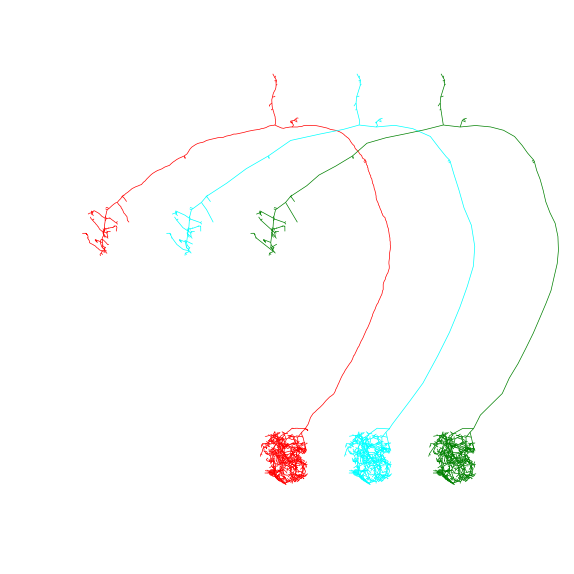

In [102]:
import matplotlib.pyplot as plt

# Plot an original neuron first
fig, ax = nl[0].plot2d(color='red')

# Shift the downsampled and resampled versions slightly and plot
n_ds = nl_downsampled[0].copy()
n_rs = nl_resampled[0].copy()

n_ds.nodes.x += 5000
n_rs.nodes.x += 10000

fig, ax = n_ds.plot2d(color='cyan', ax=ax, view=('x', '-z'))
fig, ax = n_rs.plot2d(color='green', ax=ax, view=('x', '-z'))

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

In [9]:
n = nl[0]
cut_node_id = n.nodes.node_id.values[333]
distal, proximal = navis.cut_neuron(n, cut_node_id)

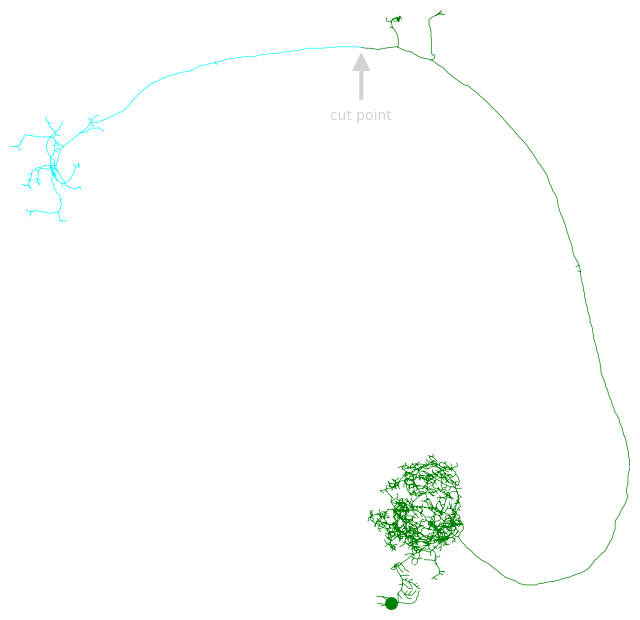

In [105]:
# Note that we are using method='2d' here because that makes annotating the plot easier
fig, ax = distal.plot2d(color='cyan', method='2d', view=('x', '-z'))
fig, ax = proximal.plot2d(color='green', ax=ax, method='2d', view=('x', '-z'))

# Annotate cut point
cut_coords = distal.nodes.set_index('node_id').loc[distal.root, ['x', 'z']].values[0]
ax.annotate('cut point',
            xy=(cut_coords[0], -cut_coords[1]),
            color='lightgrey',
            xytext=(cut_coords[0], -cut_coords[1]-2000), va='center', ha='center',
            arrowprops=dict(shrink=0.1, width=2, color='lightgrey'),
            )

plt.show()

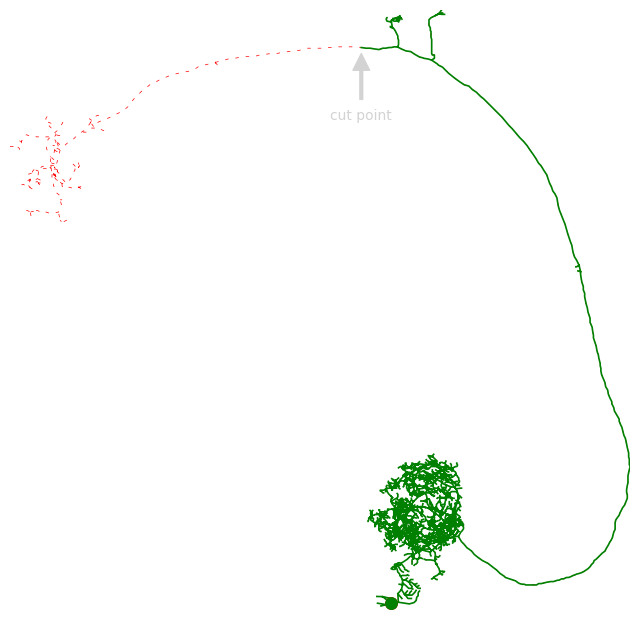

In [106]:
n_pruned = n.prune_distal_to(cut_node_id, inplace=False)

cut_coords = n.nodes.set_index('node_id').loc[cut_node_id, ['x', 'z']].values

# Plot original neuron in red and with dotted line
fig, ax = n.plot2d(color='red', method='2d', linestyle=(0, (5, 10)), view=('x', '-z'))

# Plot remaining neurires in red
fig, ax = n_pruned.plot2d(color='green', method='2d', ax=ax, view=('x', '-z'), lw=1.2)

# Annotate cut point
ax.annotate('cut point',
            xy=(cut_coords[0], -cut_coords[1]),
            color='lightgrey',
            xytext=(cut_coords[0], -cut_coords[1]-2000), va='center', ha='center',
            arrowprops=dict(shrink=0.1, width=2, color='lightgrey'),
            )

plt.show()

In [36]:
n = nl[0]
branch_points = n.nodes[n.nodes.type=='branch'].node_id.values

cut = navis.cut_neuron(n, branch_points)
cut.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,1734350788,1734350788,4,16,0,2,373.565735,None,8 nanometer
1,navis.TreeNeuron,1734350788,1734350788,5,10,0,2,431.518494,None,8 nanometer
2,navis.TreeNeuron,1734350788,1734350788,6,12,0,2,388.590637,None,8 nanometer
3,navis.TreeNeuron,1734350788,1734350788,8,22,0,2,665.534912,None,8 nanometer
4,navis.TreeNeuron,1734350788,1734350788,28,8,0,2,1534.385498,None,8 nanometer


Plot neurons:   0%|          | 0/600 [00:00<?, ?it/s]

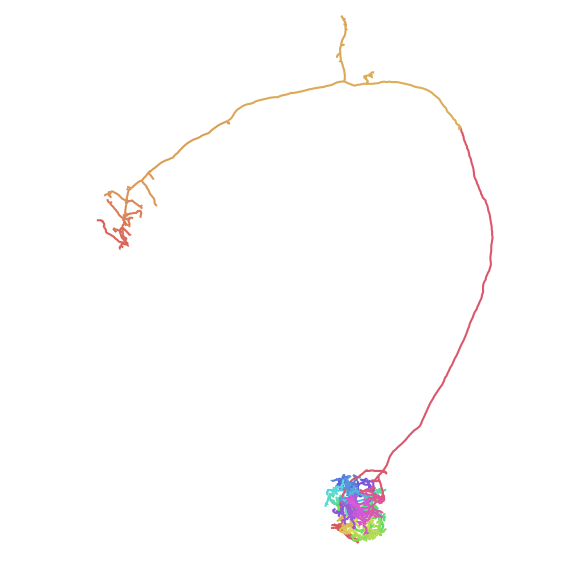

In [37]:
# Plot neuron fragments
fig, ax = navis.plot2d(cut, linewidth=1.5)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

prune_by_strahler:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

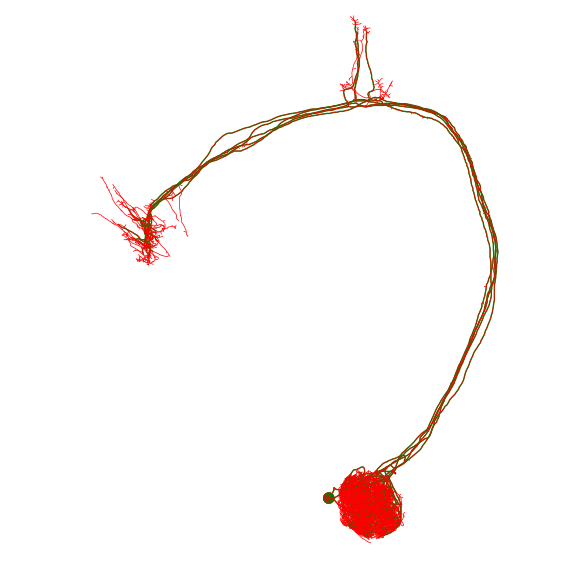

In [45]:
# This will prune off terminal branches (the lowest two Strahler indices)
nl_pruned = nl.prune_by_strahler(to_prune = [1, 2], inplace=False)

# Plot original neurons in red
fig, ax = nl.plot2d(color='red')

# Plot remaining neurites in green
fig, ax = nl_pruned.plot2d(color='green', ax=ax, linewidth=1)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

prune_by_strahler:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

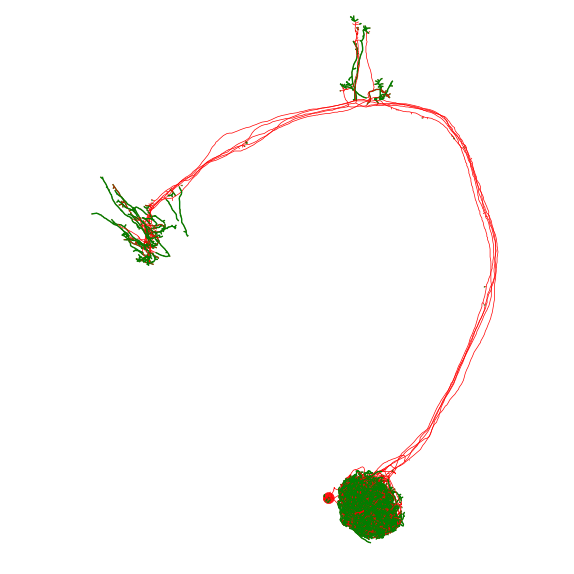

In [44]:
# This will prune the three terminal branches
nl_pruned = nl.prune_by_strahler(to_prune = range(3, 100), inplace=False)

# Plot original neurons in red
fig, ax = nl.plot2d(color='red')

# Plot remaining neurites green
fig, ax = nl_pruned.plot2d(color='green', ax=ax, linewidth=1)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

prune_twigs:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

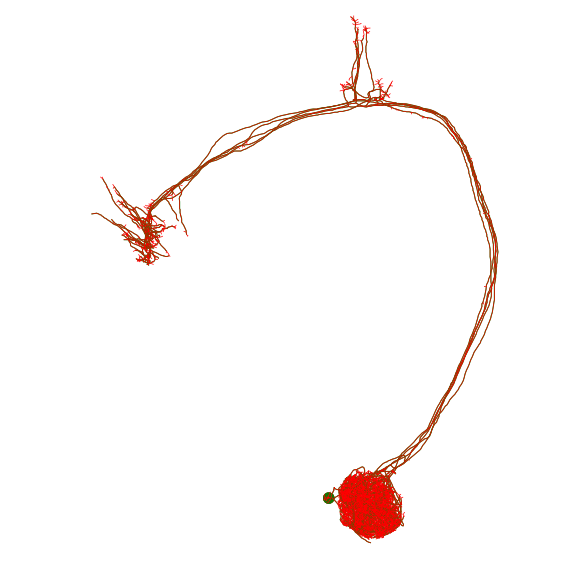

In [54]:
# This will prune all branches smaller than 5 microns
nl_pruned = nl.prune_twigs(size='5 microns', inplace=False)

# Plot original neurons in red
fig, ax = nl.plot2d(color='red')

# Plot remaining neurites in green
fig, ax = nl_pruned.plot2d(color='green', ax=ax, linewidth=.75)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

In [49]:
# Get a volume
lh = navis.example_volume('LH')

# Prune by volume
nl_lh = nl.prune_by_volume(lh, inplace=False)

prune_by_volume:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

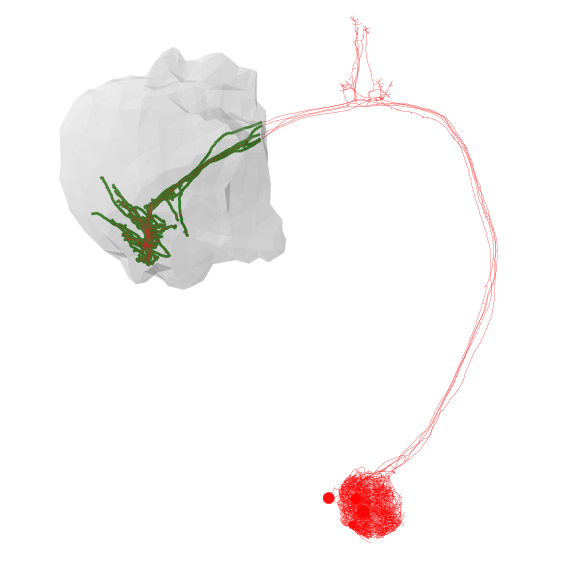

In [55]:
# Plot original neurons in red
fig, ax = navis.plot2d(nl, linewidth=.2, color='red')

# Add remaining branches in green
fig, ax = navis.plot2d([nl_lh[nl_lh.cable_length > 10], lh], ax=ax, c='green', linewidth=2)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

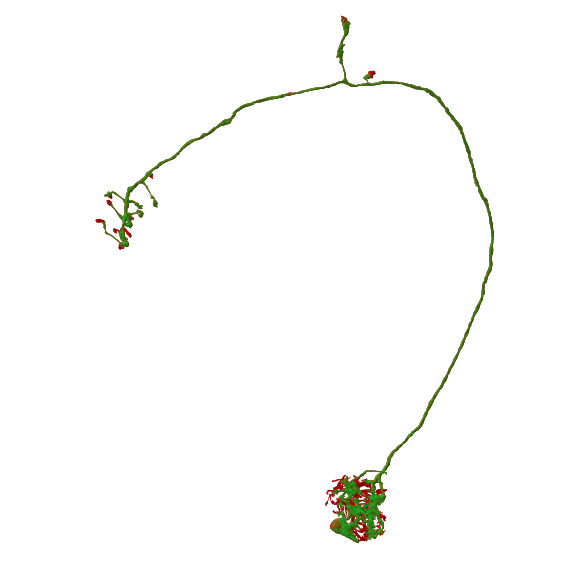

In [8]:
# Load a mesh neuron
# This is the same neuron as the first skeleton in `nl` but as mesh...
m = navis.example_neurons(1, kind='mesh')

# Prune (note that we use the `navis.prune_twigs` function directly here)
m_pruned = navis.prune_twigs(m, size='10 microns', inplace=False)

# Plot original neurons in red
fig, ax = m.plot2d(color='red')

# Plot remaining neurites in green
fig, ax = m_pruned.plot2d(color=(0.2, 1, 0.2, .5), ax=ax)

# Rotate to front view
ax.azim, ax.elev = -90, -90
ax.dist = 6

plt.show()

In [63]:
# Resample to 10um
resampled = navis.resample_skeleton(n, '10 microns', inplace=False)

# Downsample by factor 10
downsampled = navis.downsample_neuron(n, 10, inplace=False)

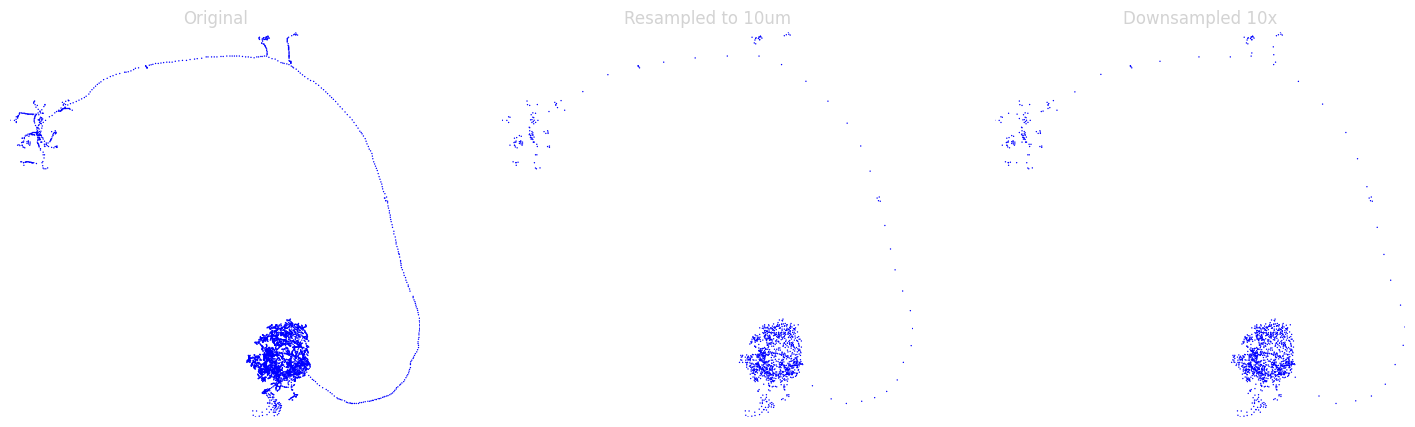

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

_ = navis.plot2d(n.nodes[['x', 'y', 'z']].values, method='2d', view=('x', '-z'), scatter_kws=dict(c='blue'),
                  ax=axes[0])

_ = navis.plot2d(resampled.nodes[['x', 'y', 'z']].values, method='2d', view=('x', '-z'), scatter_kws=dict(c='blue'),
                  ax=axes[1])

_ = navis.plot2d(downsampled.nodes[['x', 'y', 'z']].values, method='2d', view=('x', '-z'), scatter_kws=dict(c='blue'),
                  ax=axes[2])

for ax, title in zip(axes, ['Original', 'Resampled to 10um', 'Downsampled 10x']):
    ax.set_title(title, color='lightgrey')
    ax.set_axis_off()

plt.show()

In [67]:
import numpy as np

# Get nodes but remove the root (has no parent)
nodes = nl[0].nodes[nl[0].nodes.parent_id > 0]

# Get the x/y/z coordinates of all nodes (except root)
node_locs = nodes[['x', 'y', 'z']].values

# For each node, get its parent's location
parent_locs = nl[0].nodes.set_index('node_id').loc[nodes.parent_id.values, ['x', 'y', 'z']].values

# Calculate Euclidian distances
distances = np.sqrt(np.sum((node_locs - parent_locs)**2, axis=1))

# Use the neuron's units to convert into nm 
distances = distances * n.units

print(f'Mean distance between nodes: {np.mean(distances):.2f} (+/- {np.std(distances):.2f})')

Mean distance between nodes: 477.56 nanometer (+/- 361.10 nanometer)


In [69]:
n = nl[0]

end = n.nodes[n.nodes.type == 'end'].node_id.values[0]

d_geo = navis.dist_between(n, n.soma, end) * n.units

print(f'Euclidian distance between soma and terminal node {end}: {d_geo:.2f}')

Euclidian distance between soma and terminal node 465: 444096.17 nanometer


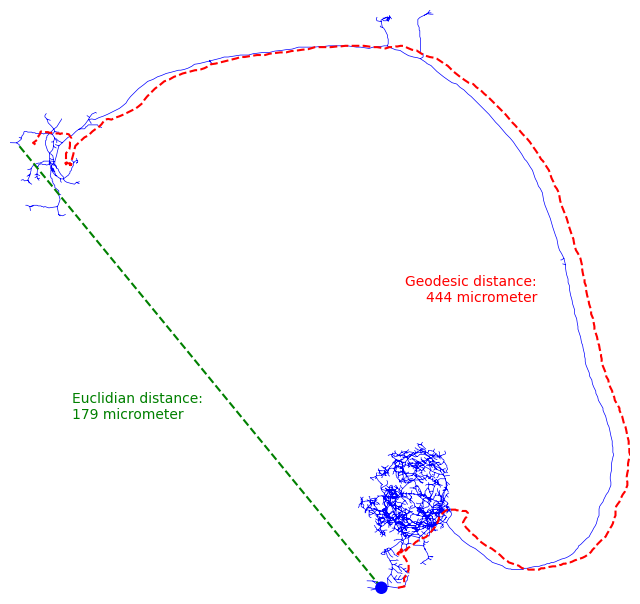

In [83]:
import networkx as nx

# First we need to find the path between the soma and the terminal node
path = nx.shortest_path(n.graph.to_undirected(), n.soma[0], end)

# Get coordinates for the path
path_co = n.nodes.set_index('node_id').loc[path, ['x', 'y', 'z']].copy()

# Add a small offset
path_co.x += 500
path_co.y -= 500

# Plot neuron
fig, ax = navis.plot2d(n, c='blue', method='2d', view=('x', '-z'))

# Add geodesic path
ax.plot(path_co.x, -path_co.z, c='r', ls='--')

# Add Euclidian path
end_loc = n.nodes.set_index('node_id').loc[end, ['x', 'y', 'z']]
soma_loc = n.nodes.set_index('node_id').loc[n.soma[0], ['x', 'y', 'z']]
ax.plot([soma_loc.x, end_loc.x], [-soma_loc.z, -end_loc.z], c='g', ls='--')

d_eucl = np.sqrt(np.sum((end_loc - soma_loc)**2)) * n.units

# Annotate distances
_ = ax.text(x=0.1, y=.3, s=f'Euclidian distance:\n{d_eucl.to_compact():.0f}', transform=ax.transAxes, c='g')
_ = ax.text(x=.85, y=.5, s=f'Geodesic distance:\n{d_geo.to_compact():.0f}', transform=ax.transAxes, c='r', ha='right')

plt.show()

In [87]:
# Calculate distances from all end nodes to all other nodes
ends = n.nodes[n.nodes.type=='end'].node_id.values
m = navis.geodesic_matrix(n, from_=ends)

# Subset to only end-nodes-to-end_nodes
m = m.loc[ends, ends]

m.head()

,465,548,618,683,745,789,832,872,911,949,...,4456,4457,4458,4459,4460,4461,4462,4463,4464,4465
465,0.000000,54395.706752,53556.405732,54489.728022,53685.768456,52679.982779,53139.882271,20944.502247,53065.272557,53873.631365,...,50402.960991,50363.976517,49936.090104,49895.070897,55185.275744,54742.764466,55158.505486,55950.521492,56111.790505,55266.165581
548,54395.706752,0.000000,8980.969668,10787.026090,6228.693973,6866.540223,8564.446208,37619.898765,8489.836493,6416.556882,...,4589.518435,5788.540454,5360.654040,5319.634833,12127.772206,11685.260928,12101.001948,12893.017955,13054.286967,12208.662044
618,53556.405732,8980.969668,0.000000,9947.725069,8271.031372,7265.245695,4698.465309,36780.597744,3951.850620,8458.894281,...,4988.223907,4060.795593,3828.188293,3866.356197,11288.471186,10845.959908,11261.700928,12053.716934,12214.985947,11369.361023
683,54489.728022,10787.026090,9947.725069,0.000000,10077.087793,9071.302116,9531.201609,37713.920034,9456.591894,10264.950703,...,6794.280329,6755.295855,6327.409441,6286.390234,12221.793476,11779.282198,12195.023218,12987.039225,13148.308237,12302.683313
745,53685.768456,6228.693973,8271.031372,10077.087793,0.000000,6156.601927,7854.507912,36909.960468,7779.898197,4485.482889,...,3879.580139,5078.602158,4650.715744,4609.696537,11417.833910,10975.322632,11391.063652,12183.079659,12344.348671,11498.723747


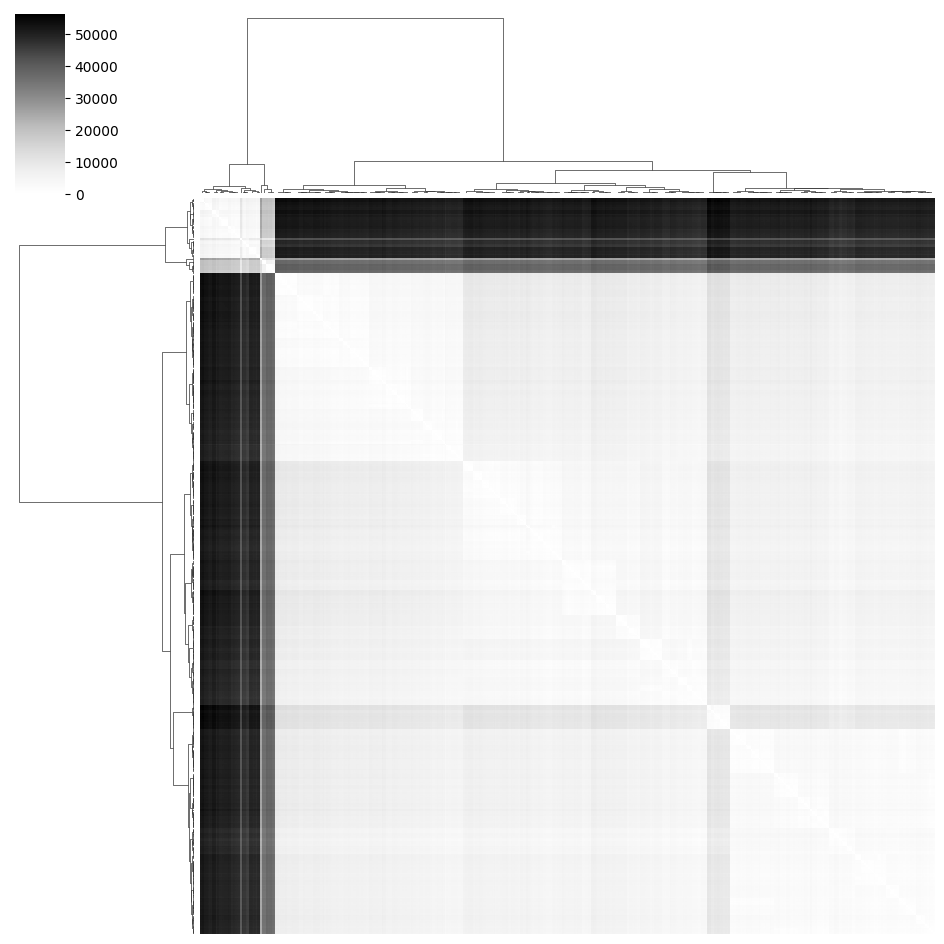

In [97]:
import seaborn as sns

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

# Generate a linkage from the distances
Z = linkage(squareform(m, checks=False), method='ward')

# Plot
cm = sns.clustermap(m, cmap='Greys', col_linkage=Z, row_linkage=Z)

cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])

plt.show()